# [[625, 25]] best neighbor search with classical distance threshold 8 (L=10, N=50)

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import generate_neighbor_highlight, from_edgelist, load_tanner_graph, parse_edgelist
from optimization.experiments_settings import codes, path_to_initial_codes, textfiles

best_neighbor_search_path = './optimization/results/best_neighbor_search_4.hdf5'

codes = ['[625,25]']
fn_data = {}

import h5py
import numpy as np

code: [625,25]
code: [625,25], valid neighbor counts per step (excluding initial): [ 6 11 14  9  6  5  6  7  6 10]
Total runtime for [625,25]: 1.0h 32.0m 54.87083911895752s
code: [625,25], min logical error rate among neighbors (excluding initial) per step: [0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385 0.0038
 0.00353]
y: [0.0122  0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385
 0.0038 ]
yerr: [0.00068041 0.00050225 0.00047147 0.00046293 0.00044536 0.00045507
 0.00042257 0.00039558 0.00038384 0.00038135]


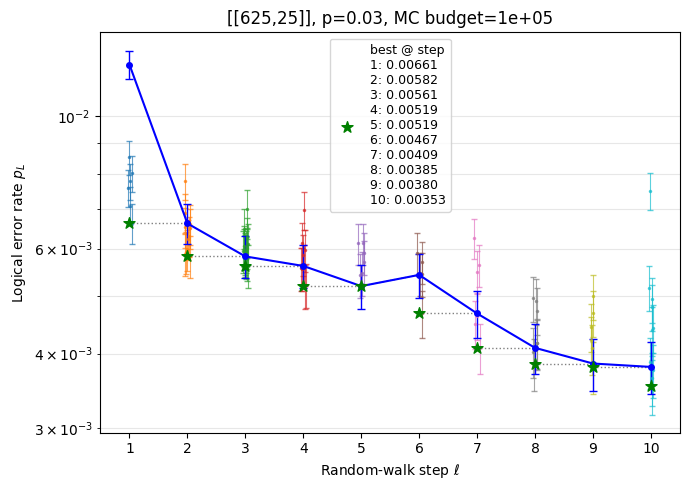

----------------------------------------------------------------------------------------------------


In [61]:
with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]

    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_classical = data['distances_classical'].reshape(L, N)  # shape (L, N)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    min_ler_each_step = np.nanmin(np.where(y[:, 1:] > 0, y[:, 1:], np.nan), axis=1)
    print(f"code: {code}, min logical error rate among neighbors (excluding initial) per step: {min_ler_each_step}")
    print(f"y: {y[:, 0]}")
    print(f"yerr: {yerr[:, 0]}")
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_classical[np.arange(L), step_best_idx]


    step_best_cost_string = "\n".join([f"{idx+1}: {v:.5f}" for idx, v in enumerate(step_best_cost)])
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step\n{step_best_cost_string}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [38]:
best_idx = np.argmin(step_best_cost) * N + step_best_idx[np.argmin(step_best_cost)]
print(f"step_best_cost: {step_best_cost}, step_best_idx[np.argmin(step_best_cost)]: {step_best_idx[np.argmin(step_best_cost)]}, best_idx: {best_idx}, np.argmin(step_best_cost): {np.argmin(step_best_cost)}")
best_state_edge_list = data['states'][best_idx]
best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']

best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

step_best_cost: [0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385 0.0038
 0.00353], step_best_idx[np.argmin(step_best_cost)]: 45, best_idx: 495, np.argmin(step_best_cost): 9
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.0004532337188720703 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.0033538341522216797 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 13.0m 56.25s with 3914 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003914 ± 0.0000624 (stderr)
Logical error rate for p=0.03: 0.003914


# logical error rate of the best state from random walk (erasure channel) with MC=1e6

In [41]:
random_walk_result_path = "./optimization/results/exploration.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
C = 0  # index into codes list
with h5py.File(random_walk_result_path, 'r') as f:
    best_state_edge_list, _ = min(((s, v) for s, v in zip(f[codes[C]]['states'], f[codes[C]]['values'])), key=lambda x: x[1])
    index_of_min = np.argmin(f[codes[C]]['values'])
    print(f"Minimum logical error rate found in state {index_of_min} with value {f[codes[C]]['values'][index_of_min][0]}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1871 with value 0.0091
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.0002949237823486328 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.0035021305084228516 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 13.0m 37.29s with 4475 failures out of 1000000 runs.
Logical error rate for Random walk: 0.004475 ± 0.0000667 (stderr)
Logical error rate for p=0.03: 0.004475


In [5]:
import numpy as np
import h5py
import scipy.sparse as sp
from optimization.experiments_settings import from_edgelist, tanner_graph_to_parity_check_matrix
from optimization.analyze_codes.decoder_performance_from_state import compute_classical_code_parameters

random_walk_result_path = "./optimization/results/exploration.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']

for C in range(len(codes)):
    with h5py.File(random_walk_result_path, 'r') as f:
        grp = f[codes[C]]

        # find argmin
        idx_min = int(np.argmin(grp['values']))
        val_min = float(np.array(grp['values'][idx_min]).ravel()[0])
        print(f"Minimum logical error rate found in state {idx_min} with value {val_min}")

        # get the raw edge data for that state
        raw = np.array(grp['states'][idx_min])

        # ensure shape is (E, 2)
        if raw.ndim == 1:
            if raw.size % 2 != 0:
                raise ValueError(f"Malformed edge list for {codes[C]} at state {idx_min}: odd length {raw.size}")
            edgelist = raw.reshape(-1, 2)
        else:
            edgelist = raw

        # rebuild the Tanner graph, then get H
        G = from_edgelist(edgelist.astype(np.int64))
        H = tanner_graph_to_parity_check_matrix(G)           # dense bool array
        H_csr = sp.csr_matrix(H, dtype=np.uint8)

        # compute [n, k, d]
        n, k, d = compute_classical_code_parameters(H_csr)
        print(f"Classical code parameters: [n={n}, k={k}, d={d}]")


Minimum logical error rate found in state 1871 with value 0.0091
Classical code parameters: [n=20, k=5, d=8]
Minimum logical error rate found in state 410 with value 0.0005
Classical code parameters: [n=28, k=7, d=10]
Minimum logical error rate found in state 37 with value 0.0012
Classical code parameters: [n=32, k=8, d=10]
Minimum logical error rate found in state 146 with value 0.0277
Classical code parameters: [n=36, k=9, d=10]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


In [69]:
simulated_annealing_result_path = "./optimization/results/simulated_annealing_beta7.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
C = 0  # index into codes list
with h5py.File(simulated_annealing_result_path, 'r') as f:
    min_cost = min(v for v in f[codes[C]]['logical_error_rates'] if v > 0)
    index_of_min = np.argmin(f[codes[C]]['logical_error_rates'])
    best_state_edge_list = f[codes[C]]['best_state'][()]
    print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
    print(f"best state edge list: {best_state_edge_list}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1995 with value 0.00378
best state edge list: [[ 0 23  0 25  0 30  0 32  1 15  1 22  1 26  1 34  2 20  2 22  2 27  2 31
   2 31  3 18  3 28  3 33  3 34  4 17  4 19  4 27  4 33  5 15  5 18  5 30
   5 34  6 15  6 21  6 27  6 29  7 20  7 22  7 23  7 26  8 17  8 17  8 25
   8 29  9 16  9 18  9 26  9 32 10 21 10 29 10 30 10 32 11 16 11 19 11 28
  11 31 12 19 12 20 12 21 12 23 13 16 13 24 13 24 13 33 14 24 14 25 14 28]]
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.00034689903259277344 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.004460811614990234 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 12.0m 56.10s with 3855 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003855 ± 0.0000620 (stderr)
Logical error rate for p=0.03: 0.003855


# [[625, 25]] best neighbor search with classical distance threshold 8 (L=15, N=50)

code: [625,25]
code: [625,25], valid neighbor counts per step (excluding initial): [ 2 13  9  8 11  9 14 10  4  9 11  8 11  7  4]
Total runtime for [625,25]: 3.0h 2.0m 59.61686301231384s
code: [625,25], min logical error rate among neighbors (excluding initial) per step: [0.00707 0.00509 0.00513 0.00518 0.00394 0.00416 0.00333 0.0033  0.00368
 0.00339 0.00348 0.00366 0.00347 0.00333 0.00346]
y: [0.01216 0.00707 0.00509 0.00513 0.00518 0.00394 0.00416 0.00333 0.0033
 0.00368 0.00339 0.00348 0.00366 0.00347 0.00333]
yerr: [0.00067931 0.00051931 0.00044107 0.00044279 0.00044493 0.00038828
 0.00039893 0.00035707 0.00035547 0.0003753  0.00036026 0.000365
 0.00037429 0.00036448 0.00035707]


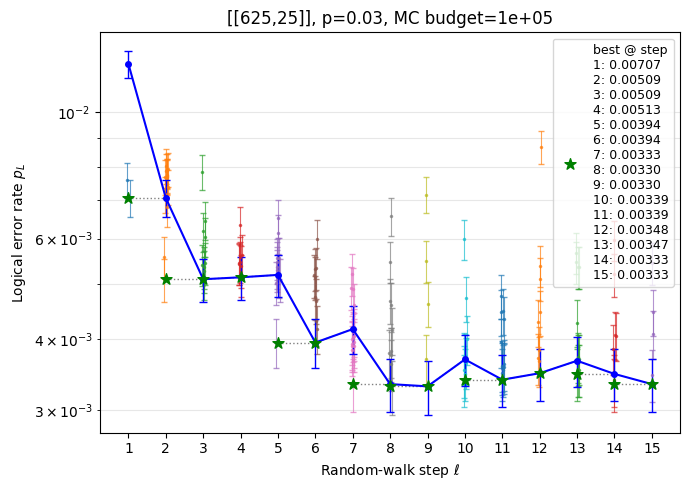

----------------------------------------------------------------------------------------------------


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import generate_neighbor_highlight, from_edgelist, load_tanner_graph, parse_edgelist
from optimization.experiments_settings import codes, path_to_initial_codes, textfiles

best_neighbor_search_path = './optimization/results/best_neighbor_search_5.hdf5'

codes = ['[625,25]']
fn_data = {}

import h5py
import numpy as np

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]

    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_classical = data['distances_classical'].reshape(L, N)  # shape (L, N)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    min_ler_each_step = np.nanmin(np.where(y[:, 1:] > 0, y[:, 1:], np.nan), axis=1)
    print(f"code: {code}, min logical error rate among neighbors (excluding initial) per step: {min_ler_each_step}")
    print(f"y: {y[:, 0]}")
    print(f"yerr: {yerr[:, 0]}")
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_classical[np.arange(L), step_best_idx]


    step_best_cost_string = "\n".join([f"{idx+1}: {v:.5f}" for idx, v in enumerate(step_best_cost)])
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step\n{step_best_cost_string}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [77]:
best_idx = np.argmin(step_best_cost) * N + step_best_idx[np.argmin(step_best_cost)]
print(f"step_best_cost: {step_best_cost}, step_best_idx[np.argmin(step_best_cost)]: {step_best_idx[np.argmin(step_best_cost)]}, best_idx: {best_idx}, np.argmin(step_best_cost): {np.argmin(step_best_cost)}")
best_state_edge_list = data['states'][best_idx]
best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']

best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

step_best_cost: [0.00707 0.00509 0.00509 0.00513 0.00394 0.00394 0.00333 0.0033  0.0033
 0.00339 0.00339 0.00348 0.00347 0.00333 0.00333], step_best_idx[np.argmin(step_best_cost)]: 7, best_idx: 357, np.argmin(step_best_cost): 7
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.00016689300537109375 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.003299236297607422 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 14.0m 26.95s with 3659 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003659 ± 0.0000604 (stderr)
Logical error rate for p=0.03: 0.003659
